# Predicting football matches results (model selection, validation, and prediction)

All created features are numerical, so I don't need to process them further. I'll split the matches dataframe into train and test:

* Train - 10 seasons, from 2011/2012 to 2020/2021
* Test - season 2021/2022 (ongoing)

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, 
                             classification_report, 
                             confusion_matrix, 
                             ConfusionMatrixDisplay, 
                             roc_auc_score, 
                             roc_curve, 
                             make_scorer)
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
import xgboost as xgb
import lightgbm as lgb

In [2]:
matches_all = pd.read_csv(
    'https://raw.githubusercontent.com/osydorchuk89/predicting_football_results/main/data/matches_all.csv'
)
matches_all.drop_duplicates(inplace=True)
train, test = matches_all.iloc[:3800, :], matches_all.iloc[3800:, :]

In [3]:
matches_all.head()

,diff_past_results,diff_past_goals,result,home_team_attack,home_team_midfield,home_team_defense,home_team_overall,home_team_past_points,home_team_past_goal_diff,home_team_past_appearances,...,diff_players_overall,diff_players_defense,diff_players_midfield,diff_players_attack,diff_goalkeepers,diff_team_past_points,diff_team_past_goal_diff,diff_team_past_appearances,diff_team_streak,diff_team_best_perf
0,3,9,away_win,74,75,73,74,44.666667,-15.666667,10,...,1.6,-6.500000,2.66,7.490909,-10,5.666667,6.333333,7,8,9
1,0,0,draw,80,76,74,76,49.333333,1.333333,10,...,4.9,2.157143,4.23,1.854545,-2,-8.666667,-1.333333,0,0,-1
2,5,10,draw,81,79,80,80,69.000000,30.333333,10,...,3.5,0.100000,0.15,-1.072727,11,26.666667,43.333333,3,6,8
3,0,0,away_win,79,76,75,75,0.000000,-69.000000,0,...,-3.9,-4.857143,-2.37,-2.881818,-1,-42.000000,-55.333333,-10,-10,-15
4,0,0,draw,71,71,73,72,41.000000,-24.666667,6,...,0.3,3.271429,0.66,-1.436364,3,41.000000,44.333333,5,6,9


For validation, I'll divide train into three folds:

* Train - seasons 2011/2012 to 2017/2018, validation - season 2018/2019
* Train - seasons 2012/2013 to 2018/2019, validation - season 2019/2020
* Train - seasons 2013/2014 to 2019/2020, validation - season 2020/2021

In [4]:
n = 380 #number of matches in a season

train_1_indices, valid_1_indices = train.iloc[:n*7].index, train.iloc[n*7:n*8].index
train_2_indices, valid_2_indices = train.iloc[n:n*8].index, train.iloc[n*8:n*9].index
train_3_indices, valid_3_indices = train.iloc[n*2:n*9].index, train.iloc[n*9:n*10].index

my_cv = [(train_1_indices, valid_1_indices), (train_2_indices, valid_2_indices), (train_3_indices, valid_3_indices)]

In [5]:
logreg = LogisticRegression(solver='liblinear', random_state=17)
rf = RandomForestClassifier(random_state=17)
xgb_clf = xgb.XGBClassifier(objective='multi:softmax', eval_metric='merror')
lgbm = lgb.LGBMClassifier(objective='multiclass', metric='multi_error')

In [6]:
diff_features = [col for col in matches_all.columns if 'diff_' in col]
home_features = [col for col in matches_all.columns if 'home_' in col]
diff_features = [col for col in matches_all.columns if 'away_' in col]

X_train = train.drop(columns='result')
y_train = train.result
y_train_num = train.result.map({'away_win': 0, 'draw': 1, 'home_win':2})

For validation, I will use two metrics: 
1. *Accuracy*. Overall share of predictions that turned out to be correct.The higher the better.
2. *Average critical errors*. this is a custom metric I developed for this task. It is calculated a share of away wins predicted as home wins and home wins predicted as away wins. I would like to minimize these errors as they are the most costly. The lower the better.
I will try to optimize predictions for these both scores.

I'll start with computing average accuracy and critical errors of predictions, using four models with defauls parameters: LogisticRegression, RandomForestClassifier, XGBClassifier, and LGBMClassifier.

In [7]:
# custom metric for calclating the share of most costly errors
def critical_errors_func(y_true, y_pred):
    errors = 0
    for pred, true in zip(y_true, y_pred):
        if ((pred == 'home_win') and (true == 'away_win')) or ((pred == 'away_win') and (true == 'home_win')):
            errors += 1
    score = errors / len(y_true)
    return score

critical_errors = make_scorer(critical_errors_func)

In [8]:
base_models = [logreg, rf, xgb_clf, lgbm]

accuracy_scores = []
critical_errors_scores = []
model_names = []

for model in base_models:
    model_name = type(model).__name__
    accuracy = cross_val_score(model, X_train, y_train, cv=my_cv, scoring='accuracy').mean() * 100
    critical_errors_score = cross_val_score(model, X_train, y_train, cv=my_cv, scoring=critical_errors).mean() * 100
    model_names.append(model_name)
    accuracy_scores.append(round(accuracy, 2))
    critical_errors_scores.append(round(critical_errors_score, 2))

pd.DataFrame({'Model': model_names, 'Accuracy': accuracy_scores, 'Critical errors': critical_errors_scores})    

,Model,Accuracy,Critical errors
0,LogisticRegression,55.18,22.63
1,RandomForestClassifier,54.56,22.98
2,XGBClassifier,51.58,21.49
3,LGBMClassifier,52.37,20.53


I'll proceed with tuning XGBoost and LightGBM models.

In [9]:
# tuning XGBoost hyperparameters
xgb_parameters = {
    'objective': 'multi:softmax',
    'eval_metric': 'merror',
    'num_class': 3,
    'learning_rate': 0.05,
    'max_depth': 4,
    #'min_child_weight': 1,
    #'objective': 'multi:softmax',
    #'random_seed': 17,
    #'tree_method': 'hist',
    #'grow_policy': 'lossguide',
    #'max_leaves': 4,
    #'alpha': 0.05,
    #'lambda': 1,
    'colsample_bytree': 0.8,
    'subsample': 0.8,
}

xgb_train = xgb.DMatrix(X_train, y_train_num)
xgb_results = xgb.cv(
    xgb_parameters, 
    xgb_train, 
    num_boost_round=100, 
    verbose_eval=10, 
    early_stopping_rounds=20, 
    folds=my_cv
)

xgb_results['train-accuracy-mean'] = 1 - xgb_results.iloc[:, 0]
xgb_results['test-accuracy-mean'] = 1 - xgb_results.iloc[:, 2]

xgb_results.iloc[-1:]

[0]	train-merror:0.42920+0.00124	test-merror:0.47544+0.02917
[10]	train-merror:0.41541+0.00354	test-merror:0.44035+0.03623
[20]	train-merror:0.40840+0.00204	test-merror:0.44211+0.03944
[30]	train-merror:0.39987+0.00568	test-merror:0.44474+0.03349
[40]	train-merror:0.38759+0.00162	test-merror:0.44123+0.03480
[42]	train-merror:0.38622+0.00234	test-merror:0.44211+0.03615


,train-merror-mean,train-merror-std,test-merror-mean,test-merror-std,train-accuracy-mean,test-accuracy-mean
22,0.407644,0.001278,0.439474,0.039444,0.592356,0.560526


In [10]:
# tuning LightGBM hyperparameters
lgb_parameters = {
  'objective': 'multiclass',
  'metric': 'multi_error', 
  'num_class': 3,
  'learning_rate': 0.01,
  'verbose': -1,
  'subsample_freq': 1,
  'subsample': 0.8,
  'colsample_bytree': 0.8, 
  'min_child_samples': 30,
  'random_seed': 17
}

lgb_train = lgb.Dataset(X_train, y_train_num)

lgb_results = lgb.cv(
    lgb_parameters, 
    lgb_train, 
    num_boost_round=1000, 
    folds=my_cv, 
    early_stopping_rounds=50, 
    verbose_eval=10, 
    eval_train_metric=True
)

lgb_test_result = 1 - lgb_results['valid multi_error-mean'][-1]
lgb_train_result = 1 - lgb_results['train multi_error-mean'][-1]
lgb_best_round = len(lgb_results['valid multi_error-mean'])

print(
    f'\nTrain score is {lgb_train_result:.4f}, test score is {lgb_test_result:.4f}, stopped after {lgb_best_round} rounds'
)

[10]	cv_agg's train multi_error: 0.543734 + 0.00248108	cv_agg's valid multi_error: 0.564035 + 0.0414607
[20]	cv_agg's train multi_error: 0.525188 + 0.00825928	cv_agg's valid multi_error: 0.547368 + 0.0479978
[30]	cv_agg's train multi_error: 0.460902 + 0.00717904	cv_agg's valid multi_error: 0.504386 + 0.0518064
[40]	cv_agg's train multi_error: 0.432456 + 0.00540738	cv_agg's valid multi_error: 0.481579 + 0.0505281
[50]	cv_agg's train multi_error: 0.416792 + 0.00823834	cv_agg's valid multi_error: 0.47193 + 0.0382158
[60]	cv_agg's train multi_error: 0.403509 + 0.0101357	cv_agg's valid multi_error: 0.469298 + 0.0382158
[70]	cv_agg's train multi_error: 0.388847 + 0.00783985	cv_agg's valid multi_error: 0.463158 + 0.0341092
[80]	cv_agg's train multi_error: 0.372556 + 0.0102864	cv_agg's valid multi_error: 0.454386 + 0.0337235
[90]	cv_agg's train multi_error: 0.356015 + 0.0106906	cv_agg's valid multi_error: 0.451754 + 0.0342667
[100]	cv_agg's train multi_error: 0.3401 + 0.00732413	cv_agg's valid

In [11]:
X_test = test.drop(columns='result')
y_test = test.result
y_test_num = test.result.map({'away_win': 0, 'draw': 1, 'home_win':2})

I will now use XGBoost and LightGBM models with best identified parameters to predict results in test.

For starter, I will use the most frequent class in the training set, home win, as the baseline prediction for the test.

In [12]:
baseline_preds = np.full((176,), 'home_win')
baseline_accuracy = accuracy_score(y_test, baseline_preds) * 100
baseline_critical_errors = critical_errors_func(y_test, baseline_preds) * 100

print(f'Accuracy of predictions on test using baseline: {baseline_accuracy:.2f}%')
print(f'\nCritical errors score of predictions on test using baseline: {baseline_critical_errors:.2f}%')

Accuracy of predictions on test using baseline: 42.05%

Critical errors score of predictions on test using baseline: 31.25%


In [13]:
xgb_parameters = {
    'eval_metric': 'merror',
    'num_class': 3,
    'n_estimators': 25,
    'learning_rate': 0.05,
    'max_depth': 4,
    'objective': 'multi:softmax',
    'colsample_bytree': 0.8,
    'subsample': 0.8,
}

xgb_clf_upd = xgb.XGBClassifier(**xgb_parameters)

xgb_clf_upd.fit(X_train, y_train)
xgb_preds = xgb_clf_upd.predict(X_test)
xgb_probs = xgb_clf_upd.predict_proba(X_test)
xgb_accuracy = accuracy_score(y_test, xgb_preds) * 100
xgb_critical_errors = critical_errors_func(y_test, xgb_preds) * 100

print(f'Accuracy of predictions on test using tuned XGBoost: {xgb_accuracy:.2f}%')
print(f'\nCritical errors score of predictions on test using tuned XGBoost: {xgb_critical_errors:.2f}%')

Accuracy of predictions on test using tuned XGBoost: 53.41%

Critical errors score of predictions on test using tuned XGBoost: 19.32%


In [14]:
lgb_parameters = {
    'objective': 'multiclass',
    'metric': 'multi_error', 
    'num_class': 3,
    'learning_rate': 0.01,
    'verbose': -1,
    'subsample_freq': 1,
    'subsample': 0.8,
    'colsample_bytree': 0.8, 
    'min_child_samples': 30,
    'n_estimators': 140,
}

lgb_clf = lgb.LGBMClassifier(**lgb_parameters)

lgb_clf.fit(X_train, y_train)
lgb_preds = lgb_clf.predict(X_test)
lgb_probs = lgb_clf.predict_proba(X_test)
lgb_accuracy = accuracy_score(y_test, lgb_preds) * 100
lgb_critical_errors = critical_errors_func(y_test, lgb_preds) * 100

print(f'Accuracy of predictions on test using tuned LightGBM: {lgb_accuracy:.2f}%')
print(f'\nCritical errors score of predictions on test using tuned LightGBM: {lgb_critical_errors:.2f}%')

Accuracy of predictions on test using tuned LightGBM: 51.70%

Critical errors score of predictions on test using tuned LightGBM: 21.59%


Let's have a look at the distribution of predictions by XGBoost and compare them with actual labels.

In [15]:
unique, counts = np.unique(xgb_preds, return_counts=True)
print(np.asarray((unique, counts)).T)

[['away_win' 72]
 ['draw' 1]
 ['home_win' 103]]


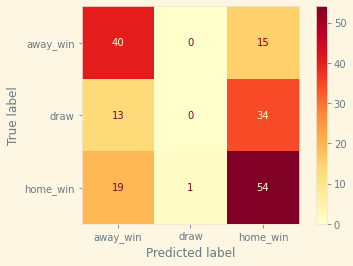

In [16]:
plt.style.use('Solarize_Light2')

cm = confusion_matrix(y_test, xgb_preds, labels=['away_win', 'draw', 'home_win'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['away_win', 'draw', 'home_win']).plot(cmap='YlOrRd')
plt.grid(False)
plt.show()

After examining the probabilities of different classes, it os obvious that sometimes the difference between probabilities of draw and home/away win is rather small. Moreover, in some cases, difference between probabilities of home and away win is very small. In these cases, it is probably more reasonable to predict draw rather then home or away win. Below, I will try to manually change thresholds for predicting classes, using cross validation and then aply the best pattern to the test set.

I'll start with manually cross validating two metrics using the tuned XGBoost model.

In [17]:
train_1, valid_1 = matches_all.iloc[:n*7], matches_all.iloc[n*7:n*8]
train_2, valid_2 = matches_all.iloc[n:n*8], matches_all.iloc[n*8:n*9]
train_3, valid_3 = matches_all.iloc[n*2:n*9], matches_all.iloc[n*9:n*10]

folds = [(train_1, valid_1), (train_2, valid_2), (train_3, valid_3)]

def train_valid_split(fold):
    X_train = fold[0].drop(columns='result')
    y_train = fold[0].result
    X_valid = fold[1].drop(columns='result')
    y_valid = fold[1].result
    return [X_train, y_train, X_valid, y_valid]

fold_1 = train_valid_split(folds[0])
fold_2 = train_valid_split(folds[1])
fold_3 = train_valid_split(folds[2])

folds_new = [fold_1, fold_2, fold_3]

In [18]:
accuracy = cross_val_score(xgb_clf_upd, X_train, y_train, cv=my_cv, scoring='accuracy').mean() * 100
critical_errors_score = cross_val_score(xgb_clf_upd, X_train, y_train, cv=my_cv, scoring=critical_errors).mean() * 100

print(f'Average accuracy score of tuned XGBClassifier is {accuracy:.2f}%')
print(f'\nAverage critical error score of tuned XGBClassifier is {critical_errors_score:.2f}%')

Average accuracy score of tuned XGBClassifier is 55.70%

Average critical error score of tuned XGBClassifier is 22.63%


In [19]:
accuracies_folds = []
critical_errors_folds = []

for fold in folds_new:
    xgb_clf_upd.fit(fold[0], fold[1])
    xgb_preds = xgb_clf_upd.predict(fold[2])
    xgb_probs = xgb_clf_upd.predict_proba(fold[2])

    upd_preds = []

    for row in xgb_probs:
        if (row[0] > row[1]) & (row[0] > row[2]):
            upd_preds.append('away_win')
        elif (row[2] > row[1]) & (row[2] > row[0]) & ((row[2] - row[0]) > 0.05):
            upd_preds.append('home_win')
        else:
            upd_preds.append('draw')

    accuracy = accuracy_score(fold[3], upd_preds) * 100
    critical_error = critical_errors_func(fold[3], upd_preds) * 100
    accuracies_folds.append(accuracy)
    critical_errors_folds.append(critical_error)
    
avg_accuracy = np.mean(accuracies_folds)
avg_citical_error = np.mean(critical_errors_folds)

print(f'Average accuracy score of tuned XGBoost after customization: {avg_accuracy:.2f}%')
print(f'\nAverage critical error score of tuned XGBoost after customization: {avg_citical_error:.2f}%')

Average accuracy score of tuned XGBoost after customization: 54.82%

Average critical error score of tuned XGBoost after customization: 19.56%


After experimenting with changing thresholds for predicting different classes, I decided to change the threshold for predicting home win. In other words, less cases will be classified as home wins and more as draws. This decreased the accuracy by 0.9% but also lowered the error by 3%.

In [20]:
xgb_clf_upd.fit(X_train, y_train)
xgb_preds = xgb_clf_upd.predict(X_test)
xgb_probs = xgb_clf_upd.predict_proba(X_test)

upd_preds = []

for row in xgb_probs:
    if (row[0] > row[1]) & (row[0] > row[2]):
        upd_preds.append('away_win')
    elif (row[2] > row[1]) & (row[2] > row[0]) & ((row[2] - row[0]) > 0.05):
        upd_preds.append('home_win')
    else:
        upd_preds.append('draw')
        
xgb_accuracy = accuracy_score(y_test, upd_preds) * 100
xgb_critical_errors = critical_errors_func(y_test, upd_preds) * 100

print(f'Accuracy of predictions on test using customized XGBoost: {xgb_accuracy:.2f}%')
print(f'\nCritical errors score of predictions on test using customized XGBoost: {xgb_critical_errors:.2f}%')

Accuracy of predictions on test using customized XGBoost: 56.82%

Critical errors score of predictions on test using customized XGBoost: 17.05%


After using the tuned XGBoost with manually set classificati threshold, the accuracy of predictions on train set increased and the error decreased.

In [21]:
unique, counts = np.unique(upd_preds, return_counts=True)
print(np.asarray((unique, counts)).T)

[['away_win' '72']
 ['draw' '19']
 ['home_win' '85']]


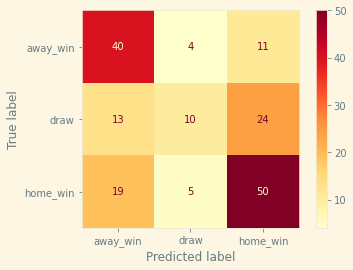

In [22]:
cm = confusion_matrix(y_test, upd_preds, labels=['away_win', 'draw', 'home_win'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['away_win', 'draw', 'home_win']).plot(cmap='YlOrRd')
plt.grid(False)
plt.show()

In [23]:
print(classification_report(y_test, upd_preds, labels=['away_win', 'draw', 'home_win']))

              precision    recall  f1-score   support

    away_win       0.56      0.73      0.63        55
        draw       0.53      0.21      0.30        47
    home_win       0.59      0.68      0.63        74

    accuracy                           0.57       176
   macro avg       0.56      0.54      0.52       176
weighted avg       0.56      0.57      0.54       176



The number of cases predicted as draws increased, and the number of critical errors decreased a bit.

Let's examine importance of different features.

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

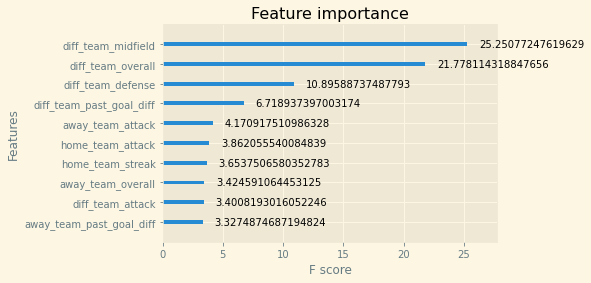

In [39]:
xgb.plot_importance(xgb_clf_upd, importance_type='gain', max_num_features=10)

The most important features are those related to difference between teams' and players' attributes. This is not surprising as they related to the outcome of the match directly. Overall mean of attributes seems the most important, followed by midfield and defense skills.

I will now create dataframe that wil combine predictions, probabilities of different outcomes, and true results.

In [25]:
probs_home_win = []
probs_draw = []
probs_away_win = []

for row in xgb_probs:
    prob_away_win = row[0] * 100
    prob_draw = row[1] * 100
    prob_home_win = row[2] * 100
    probs_away_win.append(prob_away_win)
    probs_draw.append(prob_draw)
    probs_home_win.append(prob_home_win)

In [26]:
predicted_results = pd.DataFrame({
    'preds': upd_preds, 
    'home_win_prob': np.round(probs_home_win, 2), 
    'draw_prob': np.round(probs_draw, 2), 
    'away_win_prob': np.round(probs_away_win, 2),
    'true_labels': y_test
})

In [27]:
matches = pd.read_csv(
    'https://raw.githubusercontent.com/osydorchuk89/predicting_football_results/main/data/matches.csv'
)
matches.drop_duplicates(inplace=True)
matches_2021 = matches[matches.year==2021]

In [28]:
predicted_results.insert(0, 'home_team', matches_2021.home.values)
predicted_results.insert(1, 'away_team', matches_2021.away.values)

In [29]:
predicted_results.head()

,home_team,away_team,preds,home_win_prob,draw_prob,away_win_prob,true_labels
3800,Brentford,Arsenal,away_win,31.70,28.93,39.37,home_win
3801,Manchester United,Leeds United,home_win,58.78,22.29,18.92,home_win
3802,Burnley,Brighton & Hove Albion,home_win,45.97,26.38,27.65,away_win
3803,Chelsea,Crystal Palace,home_win,60.66,20.79,18.55,home_win
3804,Everton,Southampton,home_win,52.07,28.01,19.91,home_win


I will add information about future matches. In this case, however, we won't have true labels as these matches haven't happened yet.

In [30]:
future_matches_names = pd.read_csv(
    'https://raw.githubusercontent.com/osydorchuk89/predicting_football_results/main/data/future_matches_names.csv'
)

I will predict outcomes of future matches using only team-related attributes.

In [31]:
team_attributes = [col for col in train.columns if 'team' in col]

X_train_only_teams = train[team_attributes]

test_future = pd.read_csv(
    'https://raw.githubusercontent.com/osydorchuk89/predicting_football_results/main/data/future_matches.csv'
)

In [32]:
xgb_clf_upd.fit(X_train_only_teams, y_train)
future_preds = xgb_clf_upd.predict(test_future)
future_probs = xgb_clf_upd.predict_proba(test_future)

In [33]:
future_probs_home_win = []
future_probs_draw = []
future_probs_away_win = []

for row in future_probs:
    future_prob_away_win = row[0] * 100
    future_prob_draw = row[1] * 100
    future_prob_home_win = row[2] * 100
    future_probs_away_win.append(future_prob_away_win)
    future_probs_draw.append(future_prob_draw)
    future_probs_home_win.append(future_prob_home_win)

In [34]:
future_results = pd.DataFrame({
    'preds': future_preds, 
    'home_win_prob': np.round(future_probs_home_win, 2), 
    'draw_prob': np.round(future_probs_draw, 2), 
    'away_win_prob': np.round(future_probs_away_win, 2)
})

In [35]:
future_results.insert(0, 'home_team', future_matches_names.home.values)
future_results.insert(1, 'away_team', future_matches_names.away.values)

In [36]:
combined_predictions = pd.concat([predicted_results, future_results], ignore_index=True)
combined_predictions.fillna('Unknown yet', inplace=True)
combined_predictions.replace({'away_win': 'Away team win', 'draw': 'Draw', 'home_win': 'Home team win'}, inplace=True)

In [37]:
combined_predictions.to_csv('combined_predictions.csv', index=False)

In [38]:
combined_predictions.head()

,home_team,away_team,preds,home_win_prob,draw_prob,away_win_prob,true_labels
0,Brentford,Arsenal,Away team win,31.70,28.93,39.37,Home team win
1,Manchester United,Leeds United,Home team win,58.78,22.29,18.92,Home team win
2,Burnley,Brighton & Hove Albion,Home team win,45.97,26.38,27.65,Away team win
3,Chelsea,Crystal Palace,Home team win,60.66,20.79,18.55,Home team win
4,Everton,Southampton,Home team win,52.07,28.01,19.91,Home team win
